In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [3]:
cmm_data = pd.read_csv('/home/ruggiec/Downloads/pharmacy_tx.csv')
#cmm_data_no_dups = cmm_data.drop_duplicates()
cmm_train, cmm_test = train_test_split(cmm_data, shuffle=True, 
                             random_state= 614, test_size=0.2)

In [4]:
def is_it_generic(text):
    if text.split()[0] == 'generic':
        return 1
    else:
        return 0
    
def drug_name(text):
    return text.split()[1]

def pharm_split(text):
    return int(text.split('#')[1])

In [5]:
cmm_train['generic'] = cmm_train.drug.apply(is_it_generic)
cmm_train['name'] = cmm_train['drug'].apply(drug_name)
cmm_train['private'] = cmm_train.group.isna().astype(int)
#cmm_train['popularity'] = cmm_train.groupby('name')[['tx_date']].transform('count')
#cmm_train['rejected'] = cmm_train['rejected'].astype(int)
#cmm_train['rejected_count'] = cmm_train.groupby('name')['rejected'].transform('sum')
cmm_train['pharm_num'] = cmm_train.pharmacy.apply(pharm_split)
cmm_train['tx_date'] = pd.to_datetime(cmm_train.tx_date)
cmm_train['weekday'] = cmm_train.tx_date.dt.day_of_week
cmm_train['day_num'] = cmm_train.tx_date.dt.day_of_year
cmm_train['binpcn'] = cmm_train.bin.astype(str).fillna('') + cmm_train.pcn.fillna('')
cmm_train['bingroup'] = cmm_train.bin.astype(str).fillna('') + cmm_train.group.fillna('')

In [6]:
cmm_train['binpcngroup'] = cmm_train.bin.astype(str).fillna('') + cmm_train.pcn.fillna('') + cmm_train.group.fillna('')

In [7]:
le_name = LabelEncoder()
le_name.fit(cmm_train['name'])
cmm_train['name_encoded'] = le_name.transform(cmm_train['name'])

le_diagnosis = LabelEncoder()
le_diagnosis.fit(cmm_train['diagnosis'])
cmm_train['diagnosis_encoded'] = le_diagnosis.transform(cmm_train['diagnosis'])

le_bin = LabelEncoder()
le_bin.fit(cmm_train['bin'])
cmm_train['bin_encoded'] = le_bin.transform(cmm_train['bin'])

le_pcn = LabelEncoder()
le_pcn.fit(cmm_train['pcn'])
cmm_train['pcn_encoded'] = le_pcn.transform(cmm_train['pcn'])

le_binpcn = LabelEncoder()
le_binpcn.fit(cmm_train['binpcn'])
cmm_train['binpcn_encoded'] = le_binpcn.transform(cmm_train['binpcn'])

le_bingroup = LabelEncoder()
le_bingroup.fit(cmm_train['bingroup'])
cmm_train['bingroup_encoded'] = le_bingroup.transform(cmm_train['bingroup'])

le_drug = LabelEncoder()
le_drug.fit(cmm_train['drug'])
cmm_train['drug_encoded'] = le_drug.transform(cmm_train['drug'])

In [8]:
le_binpcngroup = LabelEncoder()
cmm_train['binpcngroup_encoded'] = le_binpcngroup.fit_transform(cmm_train.binpcngroup)

In [9]:
cmm_train.columns

Index(['tx_date', 'pharmacy', 'diagnosis', 'drug', 'bin', 'pcn', 'group',
       'rejected', 'patient_pay', 'generic', 'name', 'private', 'pharm_num',
       'weekday', 'day_num', 'binpcn', 'bingroup', 'binpcngroup',
       'name_encoded', 'diagnosis_encoded', 'bin_encoded', 'pcn_encoded',
       'binpcn_encoded', 'bingroup_encoded', 'drug_encoded',
       'binpcngroup_encoded'],
      dtype='object')

In [10]:
base_features = ['diagnosis_encoded', 'binpcn_encoded',
                 'private', 'generic', 'name_encoded']
features = ['diagnosis_encoded', 'binpcn_encoded', 'bingroup_encoded',
                 'private', 'generic', 'name_encoded']
features_1 = ['diagnosis_encoded', 'binpcn_encoded', 'bingroup_encoded',
                 'private', 'drug_encoded']
features_2 = ['binpcn_encoded', 'bingroup_encoded',
                 'private', 'drug_encoded']
features_3 = ['binpcn_encoded', 'bingroup_encoded', 'drug_encoded']

features_4 = ['diagnosis_encoded', 'binpcn_encoded', 'bingroup_encoded', 'drug_encoded']

features_5 = ['binpcngroup_encoded', 'drug_encoded']

pharm_features = ['pharm_num', 'diagnosis_encoded', 'binpcn_encoded', 
                  'bingroup_encoded', 'private', 'generic', 'name_encoded']
pharm_day_features = ['day_num', 'pharm_num', 'diagnosis_encoded', 'binpcn_encoded', 
                  'bingroup_encoded', 'private', 'generic', 'name_encoded']
day_features = ['weekday', 'pharm_num', 'diagnosis_encoded', 'binpcn_encoded',
                'bingroup_encoded', 'private', 'generic', 'name_encoded']
full_features = ['weekday', 'day_num', 'pharm_num', 'diagnosis_encoded', 
                 'binpcn_encoded', 'bingroup_encoded', 'private', 'generic', 'name_encoded']

In [11]:
cmm_paid = cmm_train[cmm_train.rejected == 0]

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=614)

First go Pretty decent at 22.2% error.

In [16]:
hgbr = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4])

metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[base_features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[base_features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1

In [17]:
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 148.69125687157083
mean absolute error is 4.105900363468754
mean absolute percentage error is 0.22272943073254892


2nd go, ok. Need to work on what features are added to the mix.

In [18]:
hgbr = HistGradientBoostingRegressor(categorical_features=[0, 2, 3, 4, 5, 6, 7])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[full_features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[full_features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1

In [19]:
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 145.0209916192669
mean absolute error is 4.2746814271696225
mean absolute percentage error is 0.23378764341825456


Now we are getting somewhere. 12.5 % error lets look to see where things are not working!

In [11]:
# features

hgbr = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4, 5])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 12.96346975674939
mean absolute error is 1.9748734511228299
mean absolute percentage error is 0.12101158793220437


In [23]:
# day features 

hgbr = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[day_features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[day_features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1

In [24]:
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 14.325520427302774
mean absolute error is 2.092427781869979
mean absolute percentage error is 0.1285696522599705


In [27]:
# Pharm Features

hgbr = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4, 5, 6])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[pharm_features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[pharm_features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 14.4328767139505
mean absolute error is 2.1191945132149215
mean absolute percentage error is 0.13031466354660665


In [10]:
# Pharm day Features

hgbr = HistGradientBoostingRegressor(categorical_features=[1, 2, 3, 4, 5, 6, 7])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr.fit(cmm_paid[pharm_day_features].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr.predict(cmm_paid[pharm_day_features].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 13.352538845958298
mean absolute error is 2.1092094411427356
mean absolute percentage error is 0.13103688437497443


In [12]:
hgbr = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4, 5])
hgbr.fit(cmm_paid[features], cmm_paid['patient_pay'])
predictions = hgbr.predict(cmm_paid[features])

In [14]:
cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay

/tmp/ipykernel_49514/1292589154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay


In [18]:
cmm_paid[cmm_paid.percent_error>.50]['name_encoded'].value_counts()

19    46726
48    42084
57    39843
27    23959
25    21918
67    14560
40    13434
35    13090
1     12191
6     11657
65    11519
55    11112
52     6605
31     5942
4      5395
76     5109
66     4266
23     3957
72     3918
7      3796
10     3700
59     3368
0      2864
5      1975
69     1850
56     1782
32     1589
2      1561
45     1271
20     1105
60     1017
13      794
58      766
68      731
33      409
63      374
9       349
28      341
64      317
71      315
16      289
15      231
37      212
22      158
53      126
46      107
3       106
21      101
41      100
62       78
36       75
38       54
51       52
49       52
12       40
70       19
18        6
Name: name_encoded, dtype: int64

In [20]:
le_name.inverse_transform([19])

array(['foxivelule'], dtype=object)

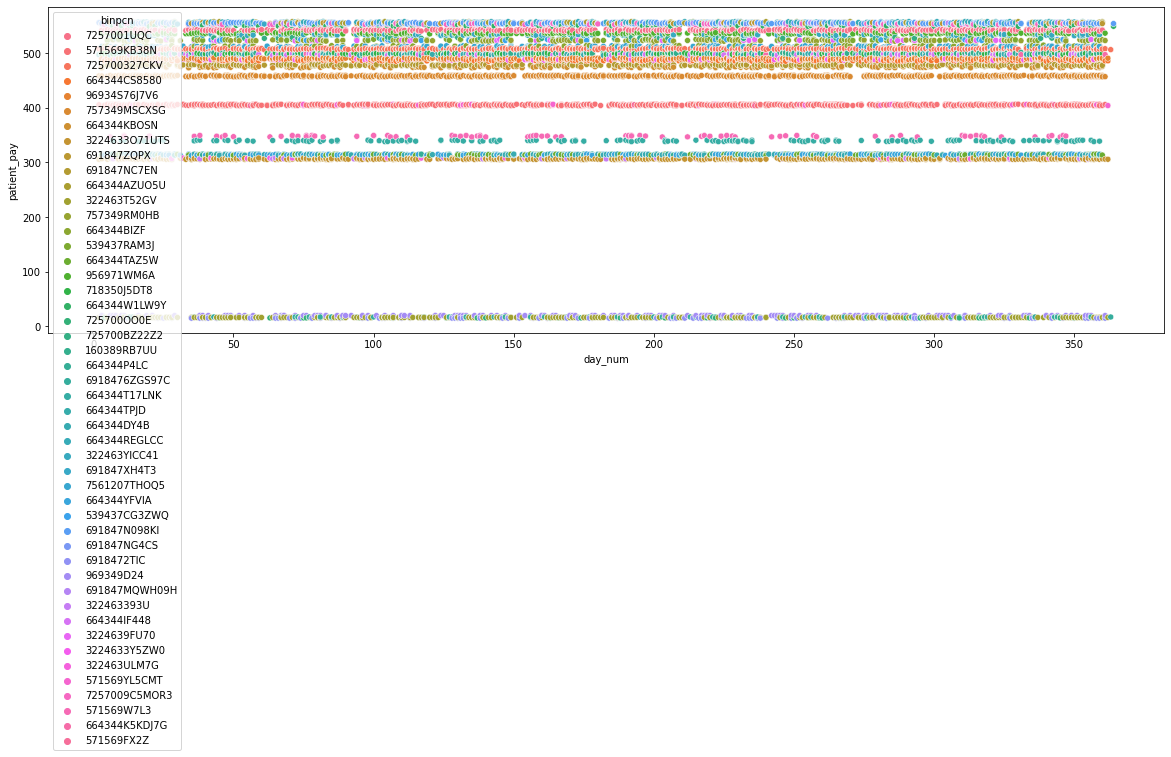

In [21]:
#This needs to be added to EDA notebook.

plt.figure(figsize=(20,6))

sns.scatterplot(x=cmm_paid[cmm_paid.name=='monemodiase'].day_num, 
                y=cmm_paid[cmm_paid.name=='monemodiase'].patient_pay,
                hue=cmm_paid.binpcn)

plt.show()

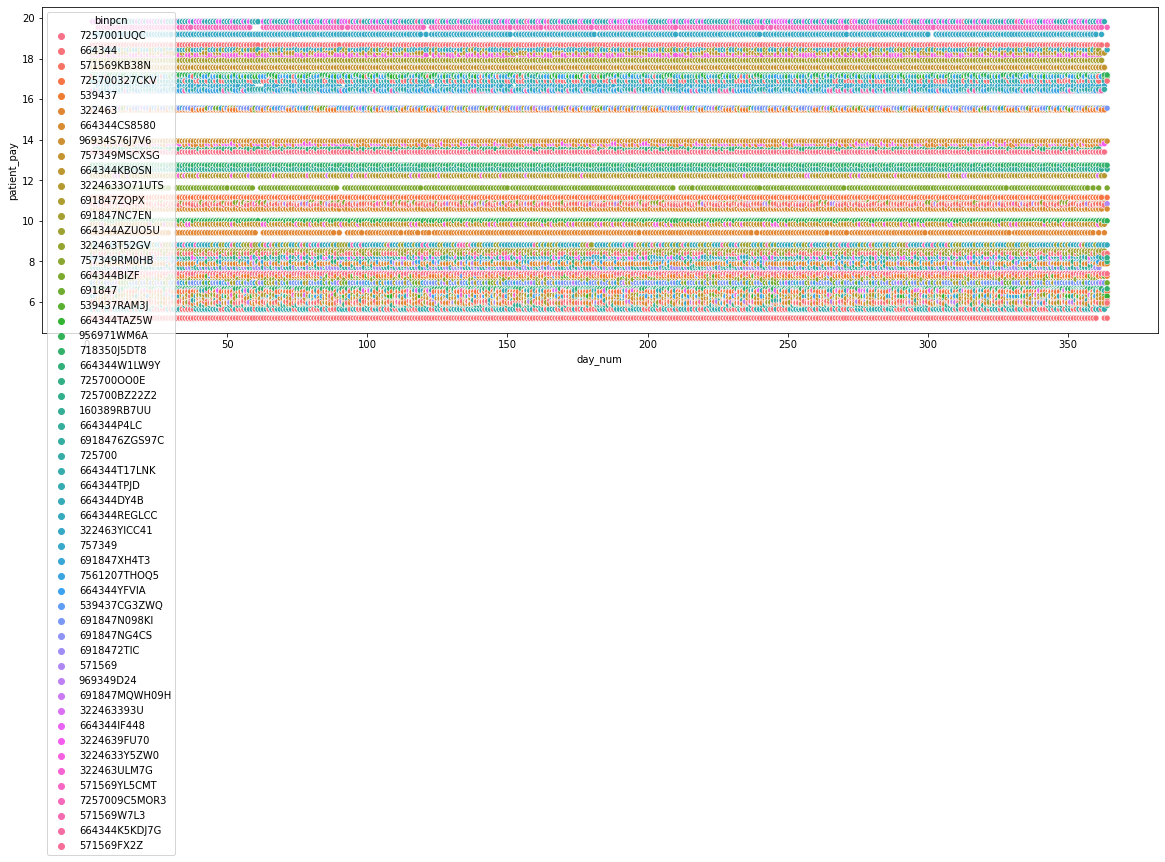

In [21]:
plt.figure(figsize=(20,6))

sns.scatterplot(x=cmm_paid[cmm_paid.name=='foxivelule'].day_num, 
                y=cmm_paid[cmm_paid.name=='foxivelule'].patient_pay,
                hue=cmm_paid.binpcn)

plt.show()

In [22]:
cmm_paid[cmm_paid.percent_error>.50]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,day_num,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,percent_error
4166337,2022-04-28,Pharmacy #51,W50.87,branded glycontazepelol,664344,YFVIA,AJK5MZ25T9IA,False,6.28,0,...,118,664344YFVIA,664344AJK5MZ25T9IA,25,115,5,44,31,21,1.073480
1273668,2022-02-09,Pharmacy #45,U60.52,branded foxivelule,322463,3O71UTS,NaN,False,6.34,0,...,40,3224633O71UTS,322463,19,102,2,4,3,1,0.522922
7566332,2022-07-26,Pharmacy #52,W50.87,branded lalol,664344,TPJD,NaN,False,6.56,0,...,207,664344TPJD,664344,35,115,5,38,29,16,0.852378
1080233,2022-02-04,Pharmacy #36,G99.93,branded hozirol,664344,REGLCC,BH2Q8B3GY2GAV,False,8.81,0,...,35,664344REGLCC,664344BH2Q8B3GY2GAV,31,37,5,32,26,22,0.760375
9933133,2022-09-23,Pharmacy #14,K32.86,branded lalol,539437,NaN,1CAHL,False,7.27,0,...,266,539437,5394371CAHL,35,57,3,48,9,9,0.821504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769377,2022-04-19,Pharmacy #49,Z98.86,branded oxasoted,571569,NaN,7LL04USF,False,5.24,0,...,109,571569,5715697LL04USF,48,132,4,48,12,13,0.665907
4936056,2022-05-20,Pharmacy #37,G99.93,generic gorol,571569,KB38N,6BYJBW,False,5.28,1,...,140,571569KB38N,5715696BYJBW,27,37,4,21,14,12,0.514249
6438583,2022-06-27,Pharmacy #23,W50.87,branded glycontazepelol,664344,DY4B,NaN,False,6.28,0,...,178,664344DY4B,664344,25,115,5,16,21,16,1.034702
3062857,2022-03-29,Pharmacy #57,G99.93,branded bovirol,956971,WM6A,L9QZA,False,6.39,0,...,88,956971WM6A,956971L9QZA,1,37,11,42,52,53,0.998294


In [24]:
cmm_paid[(cmm_paid.name == 'foxivelule') & (cmm_paid.binpcn_encoded==14)]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,day_num,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,percent_error
5749702,2022-06-11,Pharmacy #13,U41.19,branded foxivelule,571569,KB38N,6BYJBW,False,6.01,0,...,162,571569KB38N,5715696BYJBW,19,101,4,21,14,12,0.386457
5646450,2022-06-09,Pharmacy #6,U41.19,generic foxivelule,571569,KB38N,6BYJBW,False,10.84,1,...,160,571569KB38N,5715696BYJBW,19,101,4,21,14,12,0.110161
6110833,2022-06-20,Pharmacy #0,Q74.21,branded foxivelule,571569,KB38N,6BYJBW,False,6.01,0,...,171,571569KB38N,5715696BYJBW,19,87,4,21,14,12,0.386457
1884568,2022-02-24,Pharmacy #17,E71.74,branded foxivelule,571569,KB38N,6BYJBW,False,6.01,0,...,55,571569KB38N,5715696BYJBW,19,26,4,21,14,12,0.386457
5701264,2022-06-10,Pharmacy #35,U60.52,branded foxivelule,571569,KB38N,6BYJBW,False,6.01,0,...,161,571569KB38N,5715696BYJBW,19,102,4,21,14,12,0.386457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10079074,2022-09-27,Pharmacy #31,U41.19,generic foxivelule,571569,KB38N,6BYJBW,False,10.84,1,...,270,571569KB38N,5715696BYJBW,19,101,4,21,14,12,0.110161
4923474,2022-05-20,Pharmacy #52,U60.52,generic foxivelule,571569,KB38N,6BYJBW,False,10.84,1,...,140,571569KB38N,5715696BYJBW,19,102,4,21,14,12,0.110161
2229072,2022-03-08,Pharmacy #24,T57.97,branded foxivelule,571569,KB38N,6BYJBW,False,6.01,0,...,67,571569KB38N,5715696BYJBW,19,95,4,21,14,12,0.386457
9294120,2022-09-09,Pharmacy #17,T57.97,generic foxivelule,571569,KB38N,6BYJBW,False,10.84,1,...,252,571569KB38N,5715696BYJBW,19,95,4,21,14,12,0.110161


In [34]:
# features

hgbr_1 = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3, 4])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr_1.fit(cmm_paid[features_1].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr_1.predict(cmm_paid[features_1].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 11.301169477796915
mean absolute error is 1.6344553711403633
mean absolute percentage error is 0.09187893355034954


In [35]:
hgbr_1.fit(cmm_paid[features], cmm_paid['patient_pay'])
predictions = hgbr_1.predict(cmm_paid[features])

In [38]:
cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay

/tmp/ipykernel_49514/1292589154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay


In [39]:
cmm_paid.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
5469455,2022-06-05,Pharmacy #36,K87.68,branded ribosatharin,322463,T52GV,EVD4X5,False,8.21,0,...,322463T52GV,322463EVD4X5,56,59,2,36,6,3,56,0.076844
7236374,2022-07-19,Pharmacy #7,I38.43,generic colifunene,725700,327CKV,IOEAN1DWVV3Y,False,11.48,1,...,725700327CKV,725700IOEAN1DWVV3Y,7,49,8,2,44,46,82,0.012039
1443674,2022-02-13,Pharmacy #39,W50.87,branded tanoclolol,664344,NaN,77MAJF66DGD,False,17.11,0,...,664344,66434477MAJF66DGD,67,115,5,48,17,20,67,0.153252
3943243,2022-04-23,Pharmacy #43,E71.74,branded foxivelule,691847,NC7EN,NaN,False,17.91,0,...,691847NC7EN,691847,19,26,6,26,37,34,19,0.045935
5440797,2022-06-04,Pharmacy #34,I68.27,generic prazinib,322463,3O71UTS,NaN,False,10.72,1,...,3224633O71UTS,322463,52,52,2,4,3,1,99,0.040183


In [40]:
cmm_paid[cmm_paid.percent_error>.50]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
10481273,2022-10-08,Pharmacy #19,I68.27,branded prazinib,539437,RAM3J,7DUPMODV0,False,7.27,0,...,539437RAM3J,5394377DUPMODV0,52,52,3,30,11,10,52,0.745158
12569881,2022-11-25,Pharmacy #12,G99.93,generic tanoclolol,322463,NaN,HO8HUGL,False,3.45,1,...,322463,322463HO8HUGL,67,37,2,48,1,4,109,0.577752
4296424,2022-05-05,Pharmacy #31,K87.68,branded kediborin,96934,9D24,VC81HUO7ZD,False,10.02,0,...,969349D24,96934VC81HUO7ZD,33,59,0,9,53,55,33,0.506278
915851,2022-01-27,Pharmacy #53,I68.27,branded prazinib,664344,T17LNK,Z01MLD4I,False,6.84,0,...,664344T17LNK,664344Z01MLD4I,52,52,5,35,27,32,52,0.810492
12108699,2022-11-15,Pharmacy #25,Q72.66,generic ratin,322463,NaN,HO8HUGL,False,6.20,1,...,322463,322463HO8HUGL,55,86,2,48,1,4,101,0.623950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3062857,2022-03-29,Pharmacy #57,G99.93,branded bovirol,956971,WM6A,L9QZA,False,6.39,0,...,956971WM6A,956971L9QZA,1,37,11,42,52,53,1,1.126757
12258496,2022-11-18,Pharmacy #31,K32.86,generic rulfalol,160389,RB7UU,RS5RB3YA,False,5.32,1,...,160389RB7UU,160389RS5RB3YA,57,57,1,31,0,0,103,0.609435
13473918,2022-12-17,Pharmacy #50,E49.13,branded lixegimoric,691847,NG4CS,GQIGYFQQ2WGH,False,12.49,0,...,691847NG4CS,691847GQIGYFQQ2WGH,37,25,6,27,38,38,37,0.695730
4693318,2022-05-14,Pharmacy #26,Y51.55,branded glulune,757349,MSCXSG,DGLGRYP,False,17.56,0,...,757349MSCXSG,757349DGLGRYP,23,124,10,24,50,51,23,1.038375


In [41]:
cmm_paid[cmm_paid.drug == 'generic tafistitrisin']

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
3519025,2022-04-13,Pharmacy #23,K32.86,generic tafistitrisin,725700,BZ22Z2,ZOYKF0N5NEO,False,7.77,1,...,725700BZ22Z2,725700ZOYKF0N5NEO,66,57,8,13,46,48,108,0.081217
11563356,2022-11-03,Pharmacy #22,K32.86,generic tafistitrisin,956971,WM6A,L9QZA,False,10.00,1,...,956971WM6A,956971L9QZA,66,57,11,42,52,53,108,0.060082
1149527,2022-02-06,Pharmacy #26,N27.23,generic tafistitrisin,718350,J5DT8,IX6P0,False,6.65,1,...,718350J5DT8,718350IX6P0,66,71,7,19,41,42,108,0.063665
6930019,2022-07-12,Pharmacy #11,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
435267,2022-01-15,Pharmacy #32,K32.86,generic tafistitrisin,664344,YFVIA,AJK5MZ25T9IA,False,6.28,1,...,664344YFVIA,664344AJK5MZ25T9IA,66,57,5,44,31,21,108,0.645276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883243,2022-02-24,Pharmacy #17,N27.23,generic tafistitrisin,664344,REGLCC,BH2Q8B3GY2GAV,False,8.81,1,...,664344REGLCC,664344BH2Q8B3GY2GAV,66,71,5,32,26,22,108,0.009967
9518764,2022-09-14,Pharmacy #50,K32.86,generic tafistitrisin,664344,T17LNK,Z01MLD4I,False,6.01,1,...,664344T17LNK,664344Z01MLD4I,66,57,5,35,27,32,108,0.756220
5747578,2022-06-11,Pharmacy #3,N27.23,generic tafistitrisin,664344,YFVIA,AJK5MZ25T9IA,False,6.28,1,...,664344YFVIA,664344AJK5MZ25T9IA,66,71,5,44,31,21,108,0.414268
244341,2022-01-10,Pharmacy #37,K32.86,generic tafistitrisin,664344,NaN,YY6B1J4E8KJ3,False,5.85,1,...,664344,664344YY6B1J4E8KJ3,66,57,5,48,17,31,108,1.191634


In [45]:
cmm_paid[(cmm_paid.drug == 'generic tafistitrisin') & (cmm_paid.binpcn == '691847N098KI')]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
6930019,2022-07-12,Pharmacy #11,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
727151,2022-01-22,Pharmacy #7,N27.23,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,71,6,25,36,35,108,0.506154
8097611,2022-08-10,Pharmacy #50,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
10196903,2022-10-02,Pharmacy #53,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
13685369,2022-12-21,Pharmacy #1,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11424899,2022-10-31,Pharmacy #53,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
12555356,2022-11-24,Pharmacy #41,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
6764833,2022-07-08,Pharmacy #50,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175
6547785,2022-07-03,Pharmacy #23,K32.86,generic tafistitrisin,691847,N098KI,6SP1DG,False,15.55,1,...,691847N098KI,6918476SP1DG,66,57,6,25,36,35,108,0.418175


In [44]:
# features

hgbr_2 = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr_2.fit(cmm_paid[features_2].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr_2.predict(cmm_paid[features_2].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 11.419810750929177
mean absolute error is 1.644704514261763
mean absolute percentage error is 0.09228175779921455


In [47]:
cmm_paid[(cmm_paid.drug == 'generic tafistitrisin') & (cmm_paid.binpcn == '691847N098KI')]['patient_pay'].value_counts()

15.55    2166
Name: patient_pay, dtype: int64

In [49]:
cmm_paid[(cmm_paid.drug == 'generic tafistitrisin')]['patient_pay'].value_counts()

6.01     15249
5.94      6102
6.50      6028
6.28      4588
15.55     4296
9.83      4284
6.34      4230
6.17      4190
7.39      3998
7.27      2862
5.89      2791
6.56      2387
8.51      2000
5.91      1905
10.00     1810
6.65      1680
5.85      1434
8.81      1357
7.97       954
7.11       945
19.19      812
9.82       747
5.73       681
5.84       643
7.99       615
5.86       597
6.36       548
9.41       504
16.65      488
8.18       480
7.77       272
16.41      271
Name: patient_pay, dtype: int64

In [19]:
# features

hgbr_3 = HistGradientBoostingRegressor(categorical_features=[0, 1, 2])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr_3.fit(cmm_paid[features_3].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr_3.predict(cmm_paid[features_3].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 11.231161254134246
mean absolute error is 1.6170032675623642
mean absolute percentage error is 0.09096078282569704


In [21]:
hgbr_3 = HistGradientBoostingRegressor(categorical_features=[0, 1, 2])
hgbr_3.fit(cmm_paid[features_3], cmm_paid['patient_pay'])
predictions = hgbr_3.predict(cmm_paid[features_3])

In [22]:
cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay

/tmp/ipykernel_56084/1292589154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay


In [23]:
cmm_paid[cmm_paid.percent_error > 1.7]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
9441378,2022-09-12,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
12732098,2022-12-01,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
3317911,2022-04-08,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
11692408,2022-11-06,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
5503060,2022-06-06,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
9131348,2022-09-06,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
8126524,2022-08-11,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
8058352,2022-08-10,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
4499443,2022-05-10,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811
5902247,2022-06-15,Pharmacy #1,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,13.54,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.711811


In [15]:
cmm_paid[cmm_paid.drug_encoded==41]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
9668305,2022-09-17,Pharmacy #19,B45.03,branded monemodiase,322463,393U,XY5GQQ9,False,306.60,0,...,322463393U,322463XY5GQQ9,41,8,2,3,2,7,41,0.013692
10572715,2022-10-10,Pharmacy #26,B45.03,branded monemodiase,664344,YFVIA,AJK5MZ25T9IA,False,313.30,0,...,664344YFVIA,664344AJK5MZ25T9IA,41,8,5,44,31,21,41,0.032709
1996177,2022-02-27,Pharmacy #27,U75.95,branded monemodiase,96934,S76J7V6,NaN,False,490.53,0,...,96934S76J7V6,96934,41,104,0,34,54,54,41,0.001637
927816,2022-01-27,Pharmacy #7,U75.95,branded monemodiase,691847,NC7EN,NaN,False,479.52,0,...,691847NC7EN,691847,41,104,6,26,37,34,41,0.016527
10129807,2022-09-30,Pharmacy #14,U75.95,branded monemodiase,725700,1UQC,NaN,False,541.45,0,...,7257001UQC,725700,41,104,8,0,43,43,41,0.005162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061128,2022-03-29,Pharmacy #2,U75.95,branded monemodiase,664344,KBOSN,NaN,False,474.20,0,...,664344KBOSN,664344,41,104,5,22,24,16,41,0.004499
2971328,2022-03-27,Pharmacy #5,B45.03,branded monemodiase,96934,S76J7V6,NaN,False,490.60,0,...,96934S76J7V6,96934,41,8,0,34,54,54,41,0.001780
121875,2022-01-07,Pharmacy #28,U75.95,branded monemodiase,322463,T52GV,EVD4X5,False,16.29,0,...,322463T52GV,322463EVD4X5,41,104,2,36,6,3,41,0.262678
11358590,2022-10-29,Pharmacy #2,U75.95,branded monemodiase,725700,327CKV,IOEAN1DWVV3Y,False,507.60,0,...,725700327CKV,725700IOEAN1DWVV3Y,41,104,8,2,44,46,41,0.000261


In [20]:
cmm_paid[(cmm_paid.drug_encoded==41) & (cmm_paid.binpcn == '6918476ZGS97C')]['patient_pay'].value_counts()

17.11    100
Name: patient_pay, dtype: int64

In [24]:
hgbr_3 = HistGradientBoostingRegressor(categorical_features=[0, 1, 2], warm_start=True)
hgbr_3.fit(cmm_paid[features_3], cmm_paid['patient_pay'])
predictions = hgbr_3.predict(cmm_paid[features_3])

In [25]:
cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay

/tmp/ipykernel_56084/1292589154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay


In [28]:
cmm_paid[cmm_paid.percent_error > 1.5]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcn,bingroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,percent_error
7341234,2022-07-21,Pharmacy #10,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,14.20,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.523355
7882871,2022-08-06,Pharmacy #23,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
13019128,2022-12-07,Pharmacy #24,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
8325816,2022-08-16,Pharmacy #19,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
6290987,2022-06-24,Pharmacy #56,N27.23,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,71,10,48,49,50,4,1.648953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125933,2022-03-31,Pharmacy #48,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
7049528,2022-07-15,Pharmacy #37,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
7588901,2022-07-27,Pharmacy #12,K32.86,branded cibroniudosin,757349,NaN,9R3Z3QKDF3,False,5.59,0,...,757349,7573499R3Z3QKDF3,4,57,10,48,49,50,4,1.648953
8474746,2022-08-19,Pharmacy #13,K87.68,branded kediborin,322463,YICC41,MP3IQ,False,14.10,0,...,322463YICC41,322463MP3IQ,33,59,2,45,8,5,33,1.541251


In [29]:
cmm_paid.percent_error.mean()

0.08968415287717274

In [12]:
# features

hgbr_5 = HistGradientBoostingRegressor(categorical_features=[0, 1])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr_5.fit(cmm_paid[features_5].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr_5.predict(cmm_paid[features_5].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 10.570827985672755
mean absolute error is 1.537969959543559
mean absolute percentage error is 0.08546414425786641


In [13]:
hgbr_5.fit(cmm_paid[features_5], cmm_paid['patient_pay'])
predictions = hgbr_5.predict(cmm_paid[features_5])

In [14]:
cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay

/tmp/ipykernel_57813/1292589154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmm_paid['percent_error'] = abs(cmm_paid.patient_pay-predictions)/cmm_paid.patient_pay


In [15]:
cmm_paid.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcngroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,binpcngroup_encoded,percent_error
5469455,2022-06-05,Pharmacy #36,K87.68,branded ribosatharin,322463,T52GV,EVD4X5,False,8.21,0,...,322463T52GVEVD4X5,56,59,2,36,6,3,56,7,0.247346
7236374,2022-07-19,Pharmacy #7,I38.43,generic colifunene,725700,327CKV,IOEAN1DWVV3Y,False,11.48,1,...,725700327CKVIOEAN1DWVV3Y,7,49,8,2,44,46,82,51,0.038484
1443674,2022-02-13,Pharmacy #39,W50.87,branded tanoclolol,664344,NaN,77MAJF66DGD,False,17.11,0,...,66434477MAJF66DGD,67,115,5,48,17,20,67,20,0.016294
3943243,2022-04-23,Pharmacy #43,E71.74,branded foxivelule,691847,NC7EN,NaN,False,17.91,0,...,691847NC7EN,19,26,6,26,37,34,19,45,0.101741
5440797,2022-06-04,Pharmacy #34,I68.27,generic prazinib,322463,3O71UTS,NaN,False,10.72,1,...,3224633O71UTS,52,52,2,4,3,1,99,3,0.005355


In [16]:
cmm_paid[cmm_paid.percent_error>1]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,generic,...,binpcngroup,name_encoded,diagnosis_encoded,bin_encoded,pcn_encoded,binpcn_encoded,bingroup_encoded,drug_encoded,binpcngroup_encoded,percent_error
7566332,2022-07-26,Pharmacy #52,W50.87,branded lalol,664344,TPJD,NaN,False,6.56,0,...,664344TPJD,35,115,5,38,29,16,35,35,1.018245
11063635,2022-10-21,Pharmacy #24,K32.86,branded rulfalol,664344,KBOSN,NaN,False,5.32,0,...,664344KBOSN,57,57,5,22,24,16,57,27,1.020853
7835870,2022-08-05,Pharmacy #11,K32.86,branded rulfalol,725700,9C5MOR3,S2QKZ0OFNWS6X,False,5.66,0,...,7257009C5MOR3S2QKZ0OFNWS6X,57,57,8,8,45,47,57,52,1.071963
1881516,2022-02-24,Pharmacy #0,K32.86,branded lalol,664344,TPJD,NaN,False,6.56,0,...,664344TPJD,35,57,5,38,29,16,35,35,1.018245
2812157,2022-03-23,Pharmacy #1,G99.93,branded bovirol,956971,WM6A,L9QZA,False,6.02,0,...,956971WM6AL9QZA,1,37,11,42,52,53,1,60,1.189481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933786,2022-07-12,Pharmacy #45,G99.93,branded gorol,757349,NaN,9R3Z3QKDF3,False,5.53,0,...,7573499R3Z3QKDF3,27,37,10,48,49,50,27,57,1.095714
12651200,2022-11-29,Pharmacy #8,P07.55,branded brede,757349,NaN,9R3Z3QKDF3,False,6.71,0,...,7573499R3Z3QKDF3,2,79,10,48,49,50,2,57,1.431545
2780699,2022-03-22,Pharmacy #1,M42.24,branded suvinicuvir,664344,K5KDJ7G,1N5IRQ,False,6.56,0,...,664344K5KDJ7G1N5IRQ,65,67,5,20,23,18,65,26,1.007330
4359526,2022-05-06,Pharmacy #13,G99.93,branded rulfalol,664344,KBOSN,NaN,False,5.32,0,...,664344KBOSN,57,37,5,22,24,16,57,27,1.020853


In [17]:
cmm_paid.percent_error.describe()

count    1.025866e+07
mean     8.299749e-02
std      1.113231e-01
min      9.435127e-08
25%      1.702716e-02
50%      4.276896e-02
75%      1.041872e-01
max      1.555127e+00
Name: percent_error, dtype: float64

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

In [19]:
# features

gbr = GradientBoostingRegressor(random_state=1)
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    gbr.fit(cmm_paid[features_5].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = gbr.predict(cmm_paid[features_5].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 435.1326794719242
mean absolute error is 10.072371509172621
mean absolute percentage error is 0.5276049075333955


In [20]:
# features

hgbr_5 = HistGradientBoostingRegressor(loss='absolute_error', random_state=1, categorical_features=[0, 1])
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    hgbr_5.fit(cmm_paid[features_5].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = hgbr_5.predict(cmm_paid[features_5].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

mean squared error is 328.23844832956195
mean absolute error is 3.8496402548675577
mean absolute percentage error is 0.10229607166697754


In [13]:
from catboost import CatBoostRegressor

In [14]:
cbr = CatBoostRegressor(cat_features=features_5)

In [ ]:
metrics = np.zeros((5, 3))
i=0
for tt_index, ho_index in kf.split(cmm_paid):
    cbr.fit(cmm_paid[features_5].iloc[tt_index], cmm_paid['patient_pay'].iloc[tt_index])
    predictions = cbr.predict(cmm_paid[features_5].iloc[ho_index])
    metrics[i, 0] = mean_squared_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 1] = mean_absolute_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    metrics[i, 2] = mean_absolute_percentage_error(cmm_paid['patient_pay'].iloc[ho_index], predictions)
    i+=1
    
print('mean squared error is', metrics.mean(axis=0)[0])
print('mean absolute error is', metrics.mean(axis=0)[1])
print('mean absolute percentage error is', metrics.mean(axis=0)[2])

Learning rate set to 0.170067
0:	learn: 35.9767163	total: 827ms	remaining: 13m 46s
1:	learn: 32.4771860	total: 1.53s	remaining: 12m 43s
2:	learn: 29.8147413	total: 2.19s	remaining: 12m 9s
3:	learn: 27.8407186	total: 2.67s	remaining: 11m 4s
4:	learn: 26.3552932	total: 3.14s	remaining: 10m 25s
5:	learn: 25.2811405	total: 3.64s	remaining: 10m 3s
6:	learn: 24.5064477	total: 4.19s	remaining: 9m 54s
7:	learn: 23.9547247	total: 4.65s	remaining: 9m 37s
8:	learn: 23.5509383	total: 5.11s	remaining: 9m 22s
9:	learn: 23.2528633	total: 5.57s	remaining: 9m 10s
10:	learn: 23.0434384	total: 6.03s	remaining: 9m 2s
11:	learn: 22.8731892	total: 6.52s	remaining: 8m 56s
12:	learn: 22.7564337	total: 6.99s	remaining: 8m 50s
13:	learn: 22.6682357	total: 7.43s	remaining: 8m 43s
14:	learn: 22.6014409	total: 7.94s	remaining: 8m 41s
15:	learn: 22.5536602	total: 8.39s	remaining: 8m 36s
16:	learn: 22.4823603	total: 8.96s	remaining: 8m 38s
17:	learn: 22.4303752	total: 9.41s	remaining: 8m 33s
18:	learn: 22.3947395	to

155:	learn: 21.6747271	total: 1m 13s	remaining: 6m 37s
156:	learn: 21.6736546	total: 1m 13s	remaining: 6m 37s
157:	learn: 21.6724013	total: 1m 14s	remaining: 6m 36s
158:	learn: 21.6691116	total: 1m 14s	remaining: 6m 35s
159:	learn: 21.6679760	total: 1m 15s	remaining: 6m 35s
160:	learn: 21.6673729	total: 1m 15s	remaining: 6m 34s
161:	learn: 21.6669809	total: 1m 16s	remaining: 6m 34s
162:	learn: 21.6665764	total: 1m 16s	remaining: 6m 33s
163:	learn: 21.6661952	total: 1m 17s	remaining: 6m 33s
164:	learn: 21.6660769	total: 1m 17s	remaining: 6m 32s
165:	learn: 21.6657294	total: 1m 17s	remaining: 6m 31s
166:	learn: 21.6649062	total: 1m 18s	remaining: 6m 31s
167:	learn: 21.6649051	total: 1m 18s	remaining: 6m 30s
168:	learn: 21.6620565	total: 1m 19s	remaining: 6m 29s
169:	learn: 21.6616303	total: 1m 19s	remaining: 6m 29s
170:	learn: 21.6611885	total: 1m 20s	remaining: 6m 28s
171:	learn: 21.6611877	total: 1m 20s	remaining: 6m 27s
172:	learn: 21.6603790	total: 1m 20s	remaining: 6m 27s
173:	learn

305:	learn: 21.5994105	total: 2m 20s	remaining: 5m 17s
306:	learn: 21.5992337	total: 2m 20s	remaining: 5m 17s
307:	learn: 21.5985508	total: 2m 21s	remaining: 5m 16s
308:	learn: 21.5983748	total: 2m 21s	remaining: 5m 16s
309:	learn: 21.5981298	total: 2m 21s	remaining: 5m 15s
310:	learn: 21.5978549	total: 2m 22s	remaining: 5m 15s
311:	learn: 21.5976895	total: 2m 22s	remaining: 5m 15s
312:	learn: 21.5975195	total: 2m 23s	remaining: 5m 14s
313:	learn: 21.5974292	total: 2m 23s	remaining: 5m 14s
314:	learn: 21.5971637	total: 2m 24s	remaining: 5m 13s
315:	learn: 21.5969990	total: 2m 24s	remaining: 5m 13s
316:	learn: 21.5966664	total: 2m 25s	remaining: 5m 12s
317:	learn: 21.5965373	total: 2m 25s	remaining: 5m 12s
318:	learn: 21.5951130	total: 2m 26s	remaining: 5m 11s
319:	learn: 21.5944880	total: 2m 26s	remaining: 5m 11s
320:	learn: 21.5943401	total: 2m 26s	remaining: 5m 10s
321:	learn: 21.5942951	total: 2m 27s	remaining: 5m 10s
322:	learn: 21.5935973	total: 2m 27s	remaining: 5m 9s
323:	learn:

456:	learn: 21.5618415	total: 3m 28s	remaining: 4m 7s
457:	learn: 21.5615861	total: 3m 29s	remaining: 4m 7s
458:	learn: 21.5615759	total: 3m 29s	remaining: 4m 6s
459:	learn: 21.5612879	total: 3m 29s	remaining: 4m 6s
460:	learn: 21.5610174	total: 3m 30s	remaining: 4m 5s
461:	learn: 21.5606165	total: 3m 30s	remaining: 4m 5s
462:	learn: 21.5605489	total: 3m 31s	remaining: 4m 5s
463:	learn: 21.5603731	total: 3m 31s	remaining: 4m 4s
464:	learn: 21.5603270	total: 3m 32s	remaining: 4m 4s
465:	learn: 21.5602699	total: 3m 32s	remaining: 4m 3s
466:	learn: 21.5601934	total: 3m 33s	remaining: 4m 3s
467:	learn: 21.5600454	total: 3m 33s	remaining: 4m 2s
468:	learn: 21.5597516	total: 3m 34s	remaining: 4m 2s
469:	learn: 21.5592183	total: 3m 34s	remaining: 4m 1s
470:	learn: 21.5586892	total: 3m 34s	remaining: 4m 1s
471:	learn: 21.5585661	total: 3m 35s	remaining: 4m
472:	learn: 21.5582148	total: 3m 35s	remaining: 4m
473:	learn: 21.5580864	total: 3m 36s	remaining: 4m
474:	learn: 21.5579921	total: 3m 36s	

607:	learn: 21.5426280	total: 4m 37s	remaining: 2m 58s
608:	learn: 21.5425572	total: 4m 37s	remaining: 2m 58s
609:	learn: 21.5424359	total: 4m 37s	remaining: 2m 57s
610:	learn: 21.5423984	total: 4m 38s	remaining: 2m 57s
611:	learn: 21.5422438	total: 4m 38s	remaining: 2m 56s
612:	learn: 21.5419167	total: 4m 39s	remaining: 2m 56s
613:	learn: 21.5418047	total: 4m 39s	remaining: 2m 55s
614:	learn: 21.5414426	total: 4m 40s	remaining: 2m 55s
615:	learn: 21.5413896	total: 4m 40s	remaining: 2m 54s
616:	learn: 21.5411069	total: 4m 41s	remaining: 2m 54s
617:	learn: 21.5410398	total: 4m 41s	remaining: 2m 54s
618:	learn: 21.5410133	total: 4m 42s	remaining: 2m 53s
619:	learn: 21.5410041	total: 4m 42s	remaining: 2m 53s
620:	learn: 21.5409699	total: 4m 42s	remaining: 2m 52s
621:	learn: 21.5409153	total: 4m 43s	remaining: 2m 52s
622:	learn: 21.5406207	total: 4m 43s	remaining: 2m 51s
623:	learn: 21.5402329	total: 4m 44s	remaining: 2m 51s
624:	learn: 21.5402129	total: 4m 44s	remaining: 2m 50s
625:	learn

757:	learn: 21.5318163	total: 5m 44s	remaining: 1m 50s
758:	learn: 21.5317842	total: 5m 45s	remaining: 1m 49s
759:	learn: 21.5317614	total: 5m 45s	remaining: 1m 49s
760:	learn: 21.5317485	total: 5m 46s	remaining: 1m 48s
761:	learn: 21.5312128	total: 5m 46s	remaining: 1m 48s
762:	learn: 21.5311853	total: 5m 47s	remaining: 1m 47s
763:	learn: 21.5311622	total: 5m 47s	remaining: 1m 47s
764:	learn: 21.5311070	total: 5m 48s	remaining: 1m 46s
765:	learn: 21.5310750	total: 5m 48s	remaining: 1m 46s
766:	learn: 21.5310181	total: 5m 48s	remaining: 1m 45s
767:	learn: 21.5309780	total: 5m 49s	remaining: 1m 45s
768:	learn: 21.5309302	total: 5m 49s	remaining: 1m 45s
769:	learn: 21.5308727	total: 5m 50s	remaining: 1m 44s
770:	learn: 21.5308399	total: 5m 50s	remaining: 1m 44s
771:	learn: 21.5308084	total: 5m 51s	remaining: 1m 43s
772:	learn: 21.5307834	total: 5m 51s	remaining: 1m 43s
773:	learn: 21.5307725	total: 5m 52s	remaining: 1m 42s
774:	learn: 21.5307217	total: 5m 52s	remaining: 1m 42s
775:	learn

908:	learn: 21.5239459	total: 6m 51s	remaining: 41.2s
909:	learn: 21.5239136	total: 6m 52s	remaining: 40.8s
910:	learn: 21.5238822	total: 6m 52s	remaining: 40.3s
911:	learn: 21.5237897	total: 6m 53s	remaining: 39.9s
912:	learn: 21.5237881	total: 6m 53s	remaining: 39.4s
913:	learn: 21.5237712	total: 6m 53s	remaining: 38.9s
914:	learn: 21.5237581	total: 6m 54s	remaining: 38.5s
915:	learn: 21.5237421	total: 6m 54s	remaining: 38s
916:	learn: 21.5237239	total: 6m 55s	remaining: 37.6s
917:	learn: 21.5237015	total: 6m 55s	remaining: 37.1s
918:	learn: 21.5236322	total: 6m 56s	remaining: 36.7s
919:	learn: 21.5236304	total: 6m 56s	remaining: 36.2s
920:	learn: 21.5236178	total: 6m 57s	remaining: 35.8s
921:	learn: 21.5235921	total: 6m 57s	remaining: 35.3s
922:	learn: 21.5235713	total: 6m 57s	remaining: 34.9s
923:	learn: 21.5235430	total: 6m 58s	remaining: 34.4s
924:	learn: 21.5235150	total: 6m 58s	remaining: 34s
925:	learn: 21.5234960	total: 6m 59s	remaining: 33.5s
926:	learn: 21.5234475	total: 6m